In [184]:
from hatchet import *
import json
from state import State
from preprocess import PreProcess
import numpy as np
import utils
import random
import os
import seaborn as sns
from scipy import stats
import statsmodels.nonparametric.api as smnp

In [59]:
dirname = '/Users/jarus/ucd/Research/Visualisation/projects/CallFlow/.callflow'
# dirname = '/home/vidi/Work/llnl/CallFlow/.callflow'
dataset = 'calc-pi'

In [60]:
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:,.2f}'.format

# Read entire dataset

In [61]:
def replace_str_with_Node(df, graph):
        mapper = {}
        def dfs_recurse(root):
            for node in root.children: 
                mapper[node.callpath[-1]] = Node(node.nid, node.callpath, None)
                dfs_recurse(node)
        for root in graph.roots:
            mapper[root.callpath[-1]] = Node(root.nid, root.callpath, None)
            dfs_recurse(root)
        df['node'] = df['node'].apply(lambda node: mapper[node] if node in mapper else '')
        return df

In [62]:
def write_gf(state, state_name, format_of_df, write_graph=True):
    print('writing file for {0} format'.format(format_of_df))

    if write_graph:
        # dump the entire_graph as literal
        graph_literal = state.graph.to_literal(graph=state.graph, dataframe=state.df)
        graph_filepath = dirname + '/' + state_name + '/' + format_of_df + '_graph.json'
        print('File path: {0}'.format(graph_filepath))
        with open(graph_filepath, 'w') as graphFile:
            json.dump(graph_literal, graphFile)

    # dump the filtered dataframe to csv.
    df_filepath = dirname + '/' + state_name + '/' + format_of_df + '_df.csv'
    state.df.to_csv(df_filepath)

In [63]:
def read_gf(name):
    state = State()
    df_filepath = dirname + '/' + name +  '/filter_df.csv'
    entire_df_filepath = dirname + '/' + name + '/entire_df.csv'
    graph_filepath = dirname + '/' + name + '/filter_graph.json'
    entire_graph_filepath = dirname + '/' + name + '/entire_graph.json'   
    group_df_filepath = dirname + '/' + name + '/group_df.csv'

    with open(graph_filepath, 'r') as graphFile:
        data = json.load(graphFile)

    state.gf = GraphFrame()
    state.gf.from_literal_persist(data)

    with open(entire_graph_filepath, 'r') as entire_graphFile:
        entire_data = json.load(entire_graphFile)
            
    state.entire_gf = GraphFrame()
    state.entire_gf.from_literal_persist(entire_data)

    state.df = pd.read_csv(df_filepath)
    state.entire_df = pd.read_csv(entire_df_filepath)

    state.graph = state.gf.graph
    state.entire_graph = state.entire_gf.graph

    # replace df['node'] from str to the Node object.
    state.df = replace_str_with_Node(state.df, state.graph)
    state.entire_df = replace_str_with_Node(state.entire_df, state.entire_graph)
    
    state.group_df = pd.read_csv(group_df_filepath)

    return state

In [65]:
##############################################################################
# Copyright (c) 2018-2019, Lawrence Livermore National Security, LLC.
# Produced at the Lawrence Livermore National Laboratory.
#
# This file is part of Callflow.
# Created by Suraj Kesavan <kesavan1@llnl.gov>.
# LLNL-CODE-741008. All rights reserved.
#
# For details, see: https://github.com/LLNL/Callflow
# Please also read the LICENSE file for the MIT License notice.
##############################################################################

#!/usr/bin/env python3

import pandas as pd
import time 
import utils
from logger import log

class Filter:
    '''
    Filter the graphframe.
    Input: State object, parameter to filterBy (could be inclusive/exclusive, 
            filterPerc: user provided filter percentage (1-100))
    '''
    def __init__(self, state, filterBy, filterPerc):
        utils.debug('filter By:', filterBy)
        utils.debug('filter Perc:', filterPerc)
        self.state = state
        self.graph = state.entire_graph
        self.df = state.entire_df
        self.gf = state.entire_gf

        self.df.set_index(['node', 'rank'], drop=False, inplace=True)

        # self.df = pd.MultiIndex.from_frame(self.df, names=['node', 'rank'])
        self.gf.dataframe = self.df
        
        self.filterBy = filterBy
        self.filterPercInDecimals = int(filterPerc)/100
        # self.filterPercInDecimals = 0.001 
        
        self.fgf = self.run() 
        self.fgf = self.graft()

        # update df and graph after filtering.
        self.df = self.fgf.dataframe
        self.graph = self.fgf.graph

    def run(self):
        log.info('Filtering the graph.')
        t = time.time()
        if self.filterBy == "Inclusive":
            max_inclusive_time = utils.getMaxIncTime_from_gf(self.graph, self.df)
            filter_gf = self.gf.filter(lambda x: True if(x['time (inc)'] > self.filterPercInDecimals*max_inclusive_time) else False)
        elif filterBy == "Exclusive":
            max_exclusive_time = utils.getMaxExcTime_from_gf(self.graph, self.df)
            log.info('[Filter] By Exclusive time = {0})'.format(max_exclusive_time))
            filter_gf = self.gf.filter(lambda x: True if (x['time'] >= self.filterPercInDecimals*max_exclusive_time) else False)
        else:
            log.warn("Not filtering.... Can take forever. Thou were warned")
            filter_gf = self.gf
        
        log.info('[Filter] Removed {0} rows. (time={1})'.format(self.gf.dataframe.shape[0] - filter_gf.dataframe.shape[0], time.time() - t))

        return filter_gf

    def graft(self):
        log.info("Squashing the graph.")
        t = time.time()
        fgf = self.fgf.squash()
        log.info("[Squash] {1} rows in dataframe (time={0})".format(time.time() - t, fgf.dataframe.shape[0]))
        return fgf

In [64]:
def ffilter(state, filterBy, filterPerc):
        filter_obj = Filter(state, filterBy, filterPerc)

        state.gf = filter_obj.gf
        state.df = filter_obj.df
        state.graph = filter_obj.graph

        return state

In [66]:
state = read_gf(dataset)

In [67]:
print(state.df)

                   node  rank   time (inc)       time  nid  rank.1  \
0        <program root>     0   999,238.00       0.00    2       0   
1        <program root>     1   999,390.00       0.00    2       1   
2        <program root>     2 1,000,306.00       0.00    2       2   
3        <program root>     3   999,308.00       0.00    2       3   
4                  main     0   999,238.00       0.00    4       0   
..                  ...   ...          ...        ...  ...     ...   
63  <unknown procedure>     3   173,876.00       0.00   54       3   
64     <unknown file>:0     0   197,718.00 197,718.00   55       0   
65     <unknown file>:0     1   244,939.00 244,939.00   55       1   
66     <unknown file>:0     2   221,846.00 221,846.00   55       2   
67     <unknown file>:0     3   173,876.00 173,876.00   55       3   

                   name type            file  line                     module  \
0        <program root>   PF  <unknown file>     0        libmonitor.so.0.0.0 

# Half-calc-pi dataset

In [68]:
def setvalues(state):
    random = pd.Series(np.random.rand(state.df.shape[0]))
    print(random)
    state.df['time (inc)'] = state.df['time (inc)']*random
    state.df['time'] = state.df['time']*random
    state.entire_df['time (inc)'] = state.entire_df['time (inc)']*random
    state.entire_df['time'] = state.entire_df['time']*random
    state.group_df['time (inc)'] = state.group_df['time (inc)']*random
    return state

In [29]:
def create_dot_callflow_folder(dataset):
            dataset_dir = dirname + '/' + dataset
            if not os.path.exists(dataset_dir):
                utils.debug('Creating .callflow directory for dataset : {0}'.format(dataset))
                os.makedirs(dataset_dir)
    
            files = ["entire_df.csv", "filter_df.csv", "entire_graph.json", "filter_graph.json", "group_df.csv"]
            for f in files:
                if not os.path.exists(dataset_dir + '/' + f):
                    open(os.path.join(dataset_dir, f), 'w').close()

In [121]:
def create_n_runs(incoming_dataset, n, filterBy, filterPerc):
    states = {}
    for i in range(0, n):
        print("Reading dataset: ", incoming_dataset)
        state = read_gf(incoming_dataset)
        dataset = incoming_dataset + '-random-' + str(i)
        create_dot_callflow_folder(dataset)
        state = setvalues(state)
        states[dataset] = state
        write_gf(state, dataset, 'entire')
        print("Writing to entire dataset: ", dataset)
        state = ffilter(state, filterBy, filterPerc) 
        print("Writing to filter dataset: ", dataset)
        write_gf(state, dataset, 'filter')
        df_filepath = dirname + '/' + dataset + '/' +'group_df.csv'
        state.group_df.to_csv(df_filepath)
    return states

In [ ]:
states = create_n_runs('calc-pi', 10, 'Inclusive', 1)

In [222]:
def calculate_distributions(states):
    results = {}
    modules = states['calc-pi'].df['module'].unique()
    num_of_bins = {}
    kde_grid = {}
    for module in modules:
        dist = {}
        mean_dist = {}
        for idx, state in enumerate(states):
            time_inc_df = states[state].df.loc[states[state].df['module'] == module]['time (inc)'].tolist()
            dist[state] = time_inc_df
            mean_dist[state] = np.mean(time_inc_df)
        np_mean_dist = np.array(tuple(mean_dist.values()))
        num_of_bins[module] = _freedman_diaconis_bins(np_mean_dist)
        kde_grid[module] = kde(np_mean_dist)
        print(kde_grid[module][0])
        series = pd.DataFrame({ 'x':kde_grid[module][0], 'y': kde_grid[module][1] })
        print(series)
        ax = sns.lineplot(x="x", y="y", data=series)
        print(kde_grid)
        results[module] = {
            "dist": dist,
            "mean_dist": mean_dist, 
            "bins": num_of_bins,
            "kde_x": kde_grid[module][0],
            "kde_y": kde_grid[module][1]
        }
    return results

[118140.42899182 123916.22020306 129692.01141429 135467.80262552
 141243.59383676 147019.38504799 152795.17625922 158570.96747046
 164346.75868169 170122.54989293 175898.34110416 181674.13231539
 187449.92352663 193225.71473786 199001.50594909 204777.29716033
 210553.08837156 216328.8795828  222104.67079403 227880.46200526
 233656.2532165  239432.04442773 245207.83563896 250983.6268502
 256759.41806143 262535.20927267 268311.0004839  274086.79169513
 279862.58290637 285638.3741176  291414.16532883 297189.95654007
 302965.7477513  308741.53896253 314517.33017377 320293.121385
 326068.91259624 331844.70380747 337620.4950187  343396.28622994
 349172.07744117 354947.8686524  360723.65986364 366499.45107487
 372275.24228611 378051.03349734 383826.82470857 389602.61591981
 395378.40713104 401154.19834227 406929.98955351 412705.78076474
 418481.57197598 424257.36318721 430033.15439844 435808.94560968
 441584.73682091 447360.52803214 453136.31924338 458912.11045461
 464687.90166585 470463.6928

{'libmonitor.so.0.0.0': (array([118140.42899182, 123916.22020306, 129692.01141429, 135467.80262552,
       141243.59383676, 147019.38504799, 152795.17625922, 158570.96747046,
       164346.75868169, 170122.54989293, 175898.34110416, 181674.13231539,
       187449.92352663, 193225.71473786, 199001.50594909, 204777.29716033,
       210553.08837156, 216328.8795828 , 222104.67079403, 227880.46200526,
       233656.2532165 , 239432.04442773, 245207.83563896, 250983.6268502 ,
       256759.41806143, 262535.20927267, 268311.0004839 , 274086.79169513,
       279862.58290637, 285638.3741176 , 291414.16532883, 297189.95654007,
       302965.7477513 , 308741.53896253, 314517.33017377, 320293.121385  ,
       326068.91259624, 331844.70380747, 337620.4950187 , 343396.28622994,
       349172.07744117, 354947.8686524 , 360723.65986364, 366499.45107487,
       372275.24228611, 378051.03349734, 383826.82470857, 389602.61591981,
       395378.40713104, 401154.19834227, 406929.98955351, 412705.78076474,


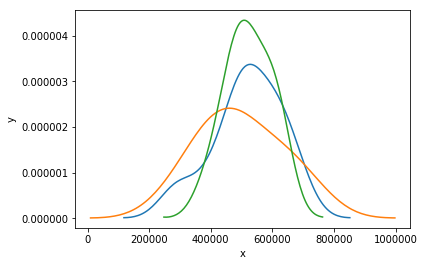

In [225]:
results = calculate_distributions(states)
print(results)

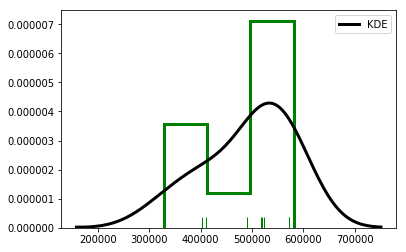

In [139]:
result = results['libmonitor.so.0.0.0']
ax = sns.distplot(result, rug=True, rug_kws={"color": "g"},
                  kde_kws={"color": "k", "lw": 3, "label": "KDE"},
                  hist_kws={"histtype": "step", "linewidth": 3,
                            "alpha": 1, "color": "g"})

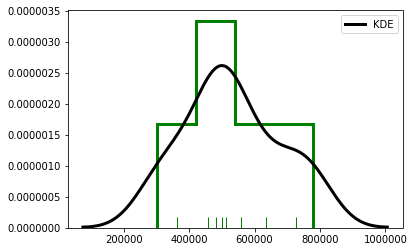

In [140]:
result = results['cpi']
ax = sns.distplot(result, rug=True, rug_kws={"color": "g"},
                  kde_kws={"color": "k", "lw": 3, "label": "KDE"},
                  hist_kws={"histtype": "step", "linewidth": 3,
                            "alpha": 1, "color": "g"})

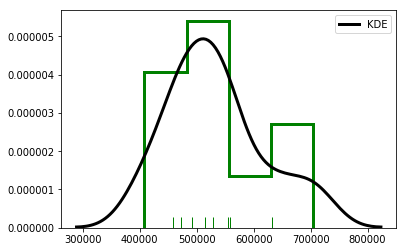

In [141]:
result = results['libmpi.so.12.0.5']
ax = sns.distplot(result, rug=True, rug_kws={"color": "g"},
                  kde_kws={"color": "k", "lw": 3, "label": "KDE"},
                  hist_kws={"histtype": "step", "linewidth": 3,
                            "alpha": 1, "color": "g"})

In [33]:
dataset = 'calc-pi-random-0'
state = read_gf(dataset)
print(state.df)

                      node  rank                  node.1  rank.1  time (inc)  \
0           <program root>     0          <program root>       0  453,871.15   
1           <program root>     1          <program root>       1   39,167.58   
2           <program root>     2          <program root>       2  177,874.70   
3           <program root>     3          <program root>       3  974,097.04   
4                     main     0                    main       0  500,962.77   
..                     ...   ...                     ...     ...         ...   
19       294:MPID_Finalize     3       294:MPID_Finalize       3   18,819.68   
20  162:MPIDI_CH3_Finalize     0  162:MPIDI_CH3_Finalize       0  930,129.75   
21  162:MPIDI_CH3_Finalize     1  162:MPIDI_CH3_Finalize       1  223,216.12   
22  162:MPIDI_CH3_Finalize     2  162:MPIDI_CH3_Finalize       2  570,273.13   
23  162:MPIDI_CH3_Finalize     3  162:MPIDI_CH3_Finalize       3  141,089.68   

    time  nid  rank.1.1                

AxesSubplot(0.125,0.125;0.775x0.755)


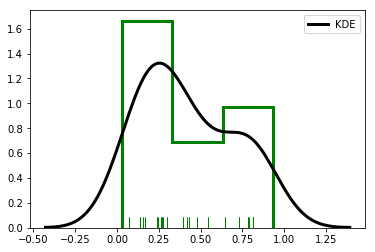

In [54]:
random = np.random.rand(state.df.shape[0])
ax = sns.distplot(random, hist=False, rug=True);
print(ax)

ax = sns.distplot(random, rug=True, rug_kws={"color": "g"},
                  kde_kws={"color": "k", "lw": 3, "label": "KDE"},
                  hist_kws={"histtype": "step", "linewidth": 3,
                            "alpha": 1, "color": "g"})

In [55]:
def iqr(a):
    """Calculate the IQR for an array of numbers."""
    a = np.asarray(a)
    q1 = stats.scoreatpercentile(a, 25)
    q3 = stats.scoreatpercentile(a, 75)
    return q3 - q1

In [182]:
def _freedman_diaconis_bins(a):
    """Calculate number of hist bins using Freedman-Diaconis rule."""
    # From https://stats.stackexchange.com/questions/798/
    a = np.asarray(a)
    if len(a) < 2:
        return 1
    h = 2 * iqr(a) / (len(a) ** (1 / 3))
    # fall back to sqrt(a) bins if iqr is 0
    if h == 0:
        return int(np.sqrt(a.size))
    else:
        return int(np.ceil((a.max() - a.min()) / h))

In [224]:
def kde(data):
    fft = True
    kernel = "gau"
    bw = 'scott'
    kde = smnp.KDEUnivariate(data)
    gridsize = 100
    cut = 3
    clip = (-np.inf, np.inf)
    kde.fit(kernel, bw, fft, gridsize=gridsize, cut=cut, clip=clip)
    cumulative = False
    if cumulative:
        grid, y = kde.support, kde.cdf
    else:
        grid, y = kde.support, kde.density
    return (grid, y)